In [1]:
from tensorflow import keras
from keras import utils
import numpy as np

img_rows,img_cols = 28,28

data = np.load('TibetanMNIST.npz')

image_data, label_data= data['image'], data['label']

print('image数据：',image_data.shape)
print('Label数据：',label_data.shape)

image数据： (17768, 28, 28)
Label数据： (17768,)


Using TensorFlow backend.


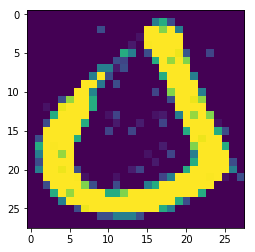

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image_data[0])

训练集处理并分割验证集

In [3]:
x_train = image_data.reshape(17768, 28, 28, 1) / 255
y_train = utils.to_categorical(label_data, 10)

from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=2018)

图片增强

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(width_shift_range = 0.1, 
                             height_shift_range = 0.1, 
                             zoom_range = 0.2)
val_gen = ImageDataGenerator()

batch_size = 64
train_generator = train_gen.flow(X_train,y_train,batch_size=batch_size, shuffle=False)
val_generator = val_gen.flow(X_val,y_val,batch_size=batch_size, shuffle=False)

创建模型

In [5]:
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
def build_model(out_dims, img_size):
    inputs_dim = Input((img_size, img_size, 1))

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inputs_dim)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same',activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same',activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same',activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same',activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same',activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    x_flat = Flatten()(x)
    dp_1 = Dropout(0.5)(x_flat)
    fc2 = Dense(out_dims)(dp_1)
    fc2 = Activation('softmax')(fc2)

    model = Model(inputs=inputs_dim, outputs=fc2)
    return model

model = build_model(out_dims=10, img_size=28)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
__________

训练模型，保存最低val_loss时的模型权重，并设置在2个epoch没有loss下降的时候降低学习率学习率

In [6]:
checkpointer = ModelCheckpoint(filepath='TibetanMNIST.hdf5', 
                              verbose=1, save_best_only=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,verbose=1,mode='min')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20

history = model.fit_generator(train_generator,
          validation_data=val_generator,
          epochs=epochs,callbacks=[checkpointer,reduce],verbose=1)

Epoch 1/20
223/223 [==============================] - 16s 72ms/step - loss: 0.5862 - acc: 0.8526 - val_loss: 0.1630 - val_acc: 0.9586

Epoch 00001: val_loss improved from inf to 0.16299, saving model to TibetanMNIST.hdf5
Epoch 2/20
223/223 [==============================] - 14s 62ms/step - loss: 0.2381 - acc: 0.9366 - val_loss: 0.1604 - val_acc: 0.9555

Epoch 00002: val_loss improved from 0.16299 to 0.16040, saving model to TibetanMNIST.hdf5
Epoch 3/20
223/223 [==============================] - 14s 62ms/step - loss: 0.1936 - acc: 0.9487 - val_loss: 0.0574 - val_acc: 0.9806

Epoch 00003: val_loss improved from 0.16040 to 0.05745, saving model to TibetanMNIST.hdf5
Epoch 4/20
223/223 [==============================] - 14s 62ms/step - loss: 0.1440 - acc: 0.9605 - val_loss: 0.2429 - val_acc: 0.9451

Epoch 00004: val_loss did not improve from 0.05745
Epoch 5/20
223/223 [==============================] - 14s 62ms/step - loss: 0.1253 - acc: 0.9673 - val_loss: 0.0552 - val_acc: 0.9845

Epoch 00

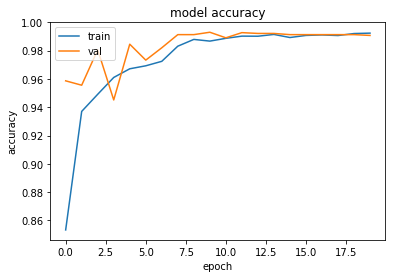

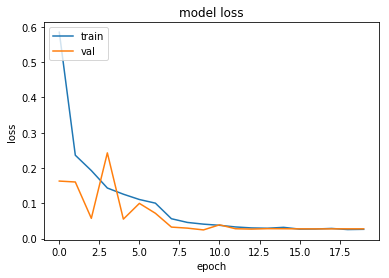

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

在第10个epoch达到val_acc: 0.9930，准确率99.3%